# Задача 10. Graph Convolutional Network
 * Найти графовый набор данных для решения задачи предсказания (классификация вершин, обнаружение сообществ и т.д.).
 * Использовать несколько слоев GCNConv из библиотеки PyG для построения GCN модели.
 * Обучить полученную модель, подобрать гиперпараметры (например, learning rate) на валидационной выборке, и оценить качество предсказания на тестовой выборке.
 * (+5 баллов) Также представить самостоятельную реализацию слоя GCNConv, используя матричные операции. Повторить обучение с собственными слоями и сравнить результаты.

In [ ]:
!pip install torch
!pip install torch_geometric
!pip install networkx
!pip install numpy
!pip install scikit-learn

## Датасет, задача
В качестве датасета был выбран CiteSeer, решается задача классификации вершин. База данных CiteSeer состоит из научных публикаций, отнесенных к одному из шести классов. Рёбра отражают ссылки между статьями. Каждая публикация в наборе данных описывается вектором слов, имеющим значение 0/1, указывающим на отсутствие/присутствие соответствующего слова в словаре.

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.utils import to_networkx
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import torch
import torch.nn.functional as F
import random

dataset = Planetoid(root='data/Planetoid', name='CiteSeer')
data = dataset[0]

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of nodes: 3327
Number of edges: 9104
Average node degree: 2.74
Number of training nodes: 120
Training node label rate: 0.04
Has self-loops: False
Is undirected: True


## Распределение вершин по классам

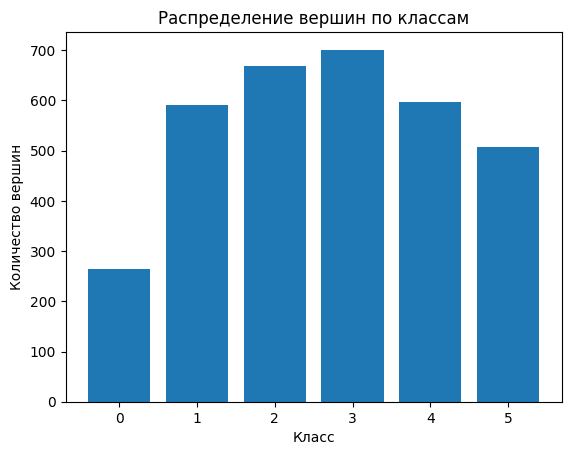

In [3]:
def get_num_classes(data):
  labels = data.y.numpy()
  num_classes = int(labels.max() + 1)
  return num_classes

num_classes = get_num_classes(data)
counts = np.bincount(data.y.numpy(), minlength=num_classes)

plt.figure()
plt.bar(np.arange(num_classes), counts)
plt.xlabel('Класс')
plt.ylabel('Количество вершин')
plt.title('Распределение вершин по классам')
plt.xticks(np.arange(num_classes))
plt.show()

## GCN модель

In [4]:
class GCN(torch.nn.Module):
    def __init__(self, conv_factory, in_channels: int, hidden_channels: int, out_channels: int, dropout: float = 0.5):
        super().__init__()
        self.conv1 = conv_factory(in_channels, hidden_channels)
        self.conv2 = conv_factory(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

## Функции для обучения модели и перебора гиперпараметров

In [5]:
from itertools import product

# зафиксировали seed для воспроизводимости
seed = 123
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, data, criterion=None):
    model.eval()
    logits = model(data.x, data.edge_index)
    preds = logits.argmax(dim=1)

    metrics = {}
    for phase in ['train', 'val', 'test']:
        mask = data[f"{phase}_mask"]
        correct = preds[mask].eq(data.y[mask]).sum().item()
        total = mask.sum().item()
        metrics[f"{phase}_acc"] = correct / total
        if criterion is not None and phase != 'train':
            loss = criterion(logits[mask], data.y[mask]).item()
            metrics[f"{phase}_loss"] = loss
    return metrics

def hyperparameter_search(conv_factory, data, param_grid, max_epochs=200):
    best_config = None
    best_val_acc = 0
    results = []

    for hidden, lr, wd, dr in product(
        param_grid['hidden_channels'],
        param_grid['lr'],
        param_grid['weight_decay'],
        param_grid['dropout']
    ):
        model = GCN(
            conv_factory=conv_factory,
            in_channels=data.num_node_features,
            hidden_channels=hidden,
            out_channels=get_num_classes(data),
            dropout=dr
        )
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        criterion = torch.nn.CrossEntropyLoss()

        best_run_val = 0
        for epoch in range(1, max_epochs + 1):
            train(model, data, optimizer, criterion)
            metrics = test(model, data)
            val_acc = metrics['val_acc']
            if val_acc > best_run_val:
                best_run_val = val_acc

        results.append(((hidden, lr, wd, dr), best_run_val))
        print(f"Config hidden={hidden}, lr={lr}, wd={wd}, dropout={dr} => best_val_acc={best_run_val:.4f}")

        if best_run_val > best_val_acc:
            best_val_acc = best_run_val
            best_config = {'hidden_channels': hidden, 'lr': lr, 'weight_decay': wd, 'dropout': dr}

    print(f"\nBest validation accuracy: {best_val_acc:.4f} with config {best_config}")
    return best_config, best_val_acc, results



## Основной цикл эксперимента

In [6]:
def experiment(conv_factory):
  dataset = Planetoid(root='data/Planetoid', name='CiteSeer')
  data = dataset[0]

  param_grid = {
      'hidden_channels': [16, 32, 64],
      'lr': [0.01, 0.005, 0.001],
      'weight_decay': [5e-4, 1e-3],
      'dropout': [0.3, 0.5]
  }

  best_config, best_val_acc, all_results = hyperparameter_search(conv_factory, data, param_grid)

  print("\nTraining final model with best hyperparameters...")
  model = GCN(
      conv_factory=default_conv_factory,
      in_channels=dataset.num_node_features,
      hidden_channels=best_config['hidden_channels'],
      out_channels=dataset.num_classes,
      dropout=best_config['dropout']
  )
  optimizer = torch.optim.Adam(model.parameters(), lr=best_config['lr'], weight_decay=best_config['weight_decay'])
  criterion = torch.nn.CrossEntropyLoss()

  best_val_acc = 0
  best_test_acc = 0
  for epoch in range(1, 251):
      train(model, data, optimizer, criterion)
      metrics = test(model, data)
      if metrics['val_acc'] >= best_val_acc:
          best_test_acc = metrics['test_acc']
      if epoch % 20 == 0:
          print(f"Epoch {epoch}: train_acc={metrics['train_acc']:.4f}, val_acc={metrics['val_acc']:.4f}, test_acc={metrics['test_acc']:.4f}")

  print(f"\nFinal test accuracy with best config: {best_test_acc:.4f}")

## Качество предсказания со стандартной реализацией

In [7]:
default_conv_factory = lambda in_c, out_c: GCNConv(in_c, out_c)
experiment(default_conv_factory)

Config hidden=16, lr=0.01, wd=0.0005, dropout=0.3 => best_val_acc=0.7040
Config hidden=16, lr=0.01, wd=0.0005, dropout=0.5 => best_val_acc=0.6900
Config hidden=16, lr=0.01, wd=0.001, dropout=0.3 => best_val_acc=0.6980
Config hidden=16, lr=0.01, wd=0.001, dropout=0.5 => best_val_acc=0.7000
Config hidden=16, lr=0.005, wd=0.0005, dropout=0.3 => best_val_acc=0.6860
Config hidden=16, lr=0.005, wd=0.0005, dropout=0.5 => best_val_acc=0.6880
Config hidden=16, lr=0.005, wd=0.001, dropout=0.3 => best_val_acc=0.6900
Config hidden=16, lr=0.005, wd=0.001, dropout=0.5 => best_val_acc=0.6920
Config hidden=16, lr=0.001, wd=0.0005, dropout=0.3 => best_val_acc=0.6760
Config hidden=16, lr=0.001, wd=0.0005, dropout=0.5 => best_val_acc=0.6340
Config hidden=16, lr=0.001, wd=0.001, dropout=0.3 => best_val_acc=0.6880
Config hidden=16, lr=0.001, wd=0.001, dropout=0.5 => best_val_acc=0.6720
Config hidden=32, lr=0.01, wd=0.0005, dropout=0.3 => best_val_acc=0.7020
Config hidden=32, lr=0.01, wd=0.0005, dropout=0.5

## Собственная реализация слоя GCNConv (CustomGCNConv)

In [11]:
import torch.nn as nn
from torch_geometric.utils import add_self_loops

class CustomGCNConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.weight = nn.Parameter(torch.empty(in_channels, out_channels))
        self.bias = nn.Parameter(torch.empty(out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        N = x.size(0)
        device = x.device
        edge_index, _ = add_self_loops(edge_index, num_nodes=N)

        row, col = edge_index
        deg = torch.bincount(row, minlength=N).float().to(device)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0

        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        adj_norm = torch.sparse_coo_tensor(edge_index, norm, (N, N), device=device)

        out = torch.sparse.mm(adj_norm, x)

        out = out @ self.weight
        out = out + self.bias
        return out


## Обучение с собственной реализацией слоя GCNConv и результаты

In [12]:
custom_conv_factory = lambda in_c, out_c: CustomGCNConv(in_c, out_c)
experiment(custom_conv_factory)

Config hidden=16, lr=0.01, wd=0.0005, dropout=0.3 => best_val_acc=0.6920
Config hidden=16, lr=0.01, wd=0.0005, dropout=0.5 => best_val_acc=0.6960
Config hidden=16, lr=0.01, wd=0.001, dropout=0.3 => best_val_acc=0.7060
Config hidden=16, lr=0.01, wd=0.001, dropout=0.5 => best_val_acc=0.6960
Config hidden=16, lr=0.005, wd=0.0005, dropout=0.3 => best_val_acc=0.7020
Config hidden=16, lr=0.005, wd=0.0005, dropout=0.5 => best_val_acc=0.6940
Config hidden=16, lr=0.005, wd=0.001, dropout=0.3 => best_val_acc=0.6860
Config hidden=16, lr=0.005, wd=0.001, dropout=0.5 => best_val_acc=0.6960
Config hidden=16, lr=0.001, wd=0.0005, dropout=0.3 => best_val_acc=0.6700
Config hidden=16, lr=0.001, wd=0.0005, dropout=0.5 => best_val_acc=0.6540
Config hidden=16, lr=0.001, wd=0.001, dropout=0.3 => best_val_acc=0.6820
Config hidden=16, lr=0.001, wd=0.001, dropout=0.5 => best_val_acc=0.6640
Config hidden=32, lr=0.01, wd=0.0005, dropout=0.3 => best_val_acc=0.6860
Config hidden=32, lr=0.01, wd=0.0005, dropout=0.5

## Итог
Точности модели с собственной реализацией слоя GCNConv и модели с реализацией слоя из библиотеки отличаются всего на 2% на тестовой выборке, что свидетельствует о корректности собственной реализации